In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]

    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, #number of components we have
          copy=True, #copy our training features, better set it to True
          whiten=False, # removes relative variance scales for our components, normalizes our components, better performance but more information loss
          svd_solver='auto', # solver to use for svd
          #tol='auto', # only relevant for arpack svd solver
          iterated_power='auto', # only relevant for randomized svd solver
          random_state=0 # only relevant for arpack or randomized svd solver
         )
X_train_transf = pca.fit_transform(X_train)
X_test_transf = pca.transform(X_test)

In [ ]:
#attributes we have available
print(pca.components_.shape) # principal components (100 dimensions)
print(pca.explained_variance_.shape) # explained variance of each component
print(pca.explained_variance_ratio_.shape) # explained variance ratio of each component
print(pca.mean_) # mean of dataset before centering

In [ ]:
#sum up the explained variance ratio with np.cumsum
print('total explained variance:',round(np.cumsum(pca.explained_variance_ratio_)[-1],3))

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
plt.imshow(X_train.astype(float).values[0].reshape(28,28),cmap=plt.get_cmap('gray_r'))
plt.title('Original Image')
plt.axis('off')
ax = fig.add_subplot(122)
X_rec = pca.inverse_transform(X_train_transf)
plt.imshow(X_rec[0].reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.title('Reconstructed image')
plt.axis('off')
plt.show()

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier

# Define a function to transform data using a specified method
def transform_data(X_train, X_test, method):
    """Transforms both training and test data using the provided method.

    Args:
        X_train (numpy.ndarray): Training data.
        X_test (numpy.ndarray): Test data.
        method (object): Transformation method, such as PCA.

    Returns:
        tuple: Transformed training data, transformed test data, and the method object.
    """

    X_train_transf = method.fit_transform(X_train)  # Fit the method to training data and transform it
    X_test_transf = method.transform(X_test)  # Transform test data using the fitted method
    return X_train_transf, X_test_transf, method

# Define a function to fit Random Forest classifiers and visualize feature importance
def fit_and_visualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, pca):
    """Fits Random Forest Classifiers on original and transformed data,
    visualizes feature importance, and compares performance.
    """

    rf_clf = RandomForestClassifier(random_state=0)  # Create a Random Forest classifier
    rc_clf_red = RandomForestClassifier(random_state=0)  # Create another Random Forest classifier

    start = time.time()  # Start time for original data fitting
    rf_clf.fit(X_train, y_train)  # Fit the classifier on original training data
    rcFit = time.time() - start  # Calculate fitting time

    start = time.time()  # Start time for transformed data fitting
    rc_clf_red.fit(X_train_transf, y_train)  # Fit the classifier on transformed training data
    rcRedFit = time.time() - start  # Calculate fitting time

    # Visualize feature importance for both classifiers (of each pixel)
    fig = plt.figure(figsize=(16, 8))  # Create a figure with two subplots
    ax = fig.add_subplot(121)  # Add the first subplot
    # Create an image plot of original feature importance
    plt.imshow(rf_clf.feature_importances_.reshape(28, 28), cmap=plt.get_cmap('gray_r'))
    plt.title(f"Original feature importance, accuracy: {round(rf_clf.score(X_test, y_test), 3)}, fit time: {round(rcFit, 2)}s")
    plt.axis('off')  # Turn off axis labels

    ax = fig.add_subplot(122)  # Add the second subplot
    rc_clf_feat_rec = pca.inverse_transform(rc_clf_red.feature_importances_)  # Reconstruct feature importance using PCA
    # Create an image plot of reconstructed feature importance
    plt.imshow(rc_clf_feat_rec.reshape(28, -1), cmap=plt.get_cmap('gray_r'))
    plt.title(f"Reconstructed feature importance, accuracy: {round(rc_clf_red.score(X_test_transf, y_test), 3)}, fit time: {round(rcRedFit, 2)}s")
    plt.axis('off')  # Turn off axis labels

    plt.show()  # Display the plots

# Apply PCA transformation with 99% variance retained
X_train_transf, X_test_transf, method = transform_data(X_train, X_test, PCA(n_components=.99)) #keep 99% of the explained variance in our components

# Fit classifiers and visualize results
fit_and_visualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, method)

#results:
#original shows nothing, reconstructed makes it appear as a 9
#but: accuracy went down, training time went up => PCA failed in this case


In [ ]:
def fitAndVisualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, pca):
    """Fits Random Forest classifiers on original and transformed data, visualizes feature importance, and compares performance.
    """

    # Create two Random Forest classifiers
    rf_clf = RandomForestClassifier(random_state=0)
    rc_clf_red = RandomForestClassifier(random_state=0)

    # Fit the classifiers and measure fitting time
    start = time.time()
    rf_clf.fit(X_train, y_train)  # Fit on original data
    rcFit = time.time() - start

    start = time.time()
    rc_clf_red.fit(X_train_transf, y_train)  # Fit on transformed data
    rcRedFit = time.time() - start

    # Create a figure with two subplots for visualization
    fig = plt.figure(figsize=(16, 8))

    # First subplot: Original feature importance
    ax = fig.add_subplot(121)
    plt.imshow(rf_clf.feature_importances_.reshape(28, 28), cmap=plt.get_cmap('gray_r'))
    plt.title(f"Original feature importance, accuracy: {round(rf_clf.score(X_test, y_test), 3)}, fit time: {round(rcFit, 2)}s")
    plt.axis('off')

    # Second subplot: Reconstructed feature importance
    ax = fig.add_subplot(122)
    # Reshape feature importance before inverse transform (PCA expects 2D input)
    rc_clf_feat_rec = pca.inverse_transform(rc_clf_red.feature_importances_.reshape(1, -1))
    plt.imshow(rc_clf_feat_rec.reshape(28, -1), cmap=plt.get_cmap('gray_r'))
    plt.title(f"Reconstructed feature importance, accuracy: {round(rc_clf_red.score(X_test_transf, y_test), 3)}, fit time: {round(rcRedFit, 2)}s")
    plt.axis('off')

    plt.show()  # Display the plots

# Import Kernel PCA
from sklearn.decomposition import KernelPCA

# Create a Kernel PCA object with specific parameters
kpca = KernelPCA(n_components=100,
                 kernel='linear',
                 fit_inverse_transform=False, #True will increase training time!
                 eigen_solver='auto',
                 tol=0,
                 max_iter=0,
                 remove_zero_eig=False, #components that have eigenvalues of 0 gonna be removed
                 random_state=0,
                 copy_X=True,
                 n_jobs=-1
                )

# Example of accessing eigenvalues and eigenvectors (if fit_inverse_transform=True)  #inverse gets back to the original dataset
# kpca.lambas_  # eigenvalues
# kpca.alphas_  # eigenvectors

# Transform data using Kernel PCA with an RBF kernel (same as above but now with RBF instead)
X_train_transf, X_test_transf, method = transformData(X_train.astype(int).iloc[:15000], #now reduced number of training features
                                                      X_test.astype(int),
                                                      KernelPCA(n_components=100,
                                                                kernel='rbf',
                                                                gamma=20,
                                                                fit_inverse_transform=True,
                                                                n_jobs=3
                                                               )
                                                     )

# Fit classifiers and visualize results using the transformed data
fitAndVisualize(X_train.iloc[:15000],
                y_train.iloc[:15000],
                X_test,
                y_test,
                X_train_transf,
                X_test_transf,
                method)


#result:
#accuracy and training time going down (right side)
#but it's much faster than before thanks to a reduced dataset
#so both PCA implementations provided much poorer results

---------------

In [3]:
#NOW DOING PCA ON A REGRESSION PROBLEM: BOSTON DATASET
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=8)

data = load_boston()
data.keys()

X, y = data["data"], data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#you may put the PCA directly into the pipeline
#video suggests putting the pca before the standard scaler in our pipe variable
pipe = Pipeline([('std_scl',StandardScaler()),
                 ('pca',PCA(n_components=8))
                ])
X_train_transf = pipe.fit_transform(X_train)
X_test_transf = pipe.transform(X_test)

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

In [5]:
#get the explained variance using np.cumsum (cumulative sum)
print('total explained variance:',round(np.cumsum(pipe.named_steps['pca'].explained_variance_ratio_)[-1],3))

ridge = Ridge()
ridge_red = Ridge()
ridge.fit(X_train, y_train) #for the standard score
ridge_red.fit(X_train_transf, y_train) #for the transformed score

print('standard ridge score:', round(ridge.score(X_test, y_test),3))
print('Dim. red. ridge score:', round(ridge_red.score(X_test_transf, y_test),3))

#result:
#not the best R² scores

total explained variance: 0.931
standard ridge score: 0.58
Dim. red. ridge score: 0.512


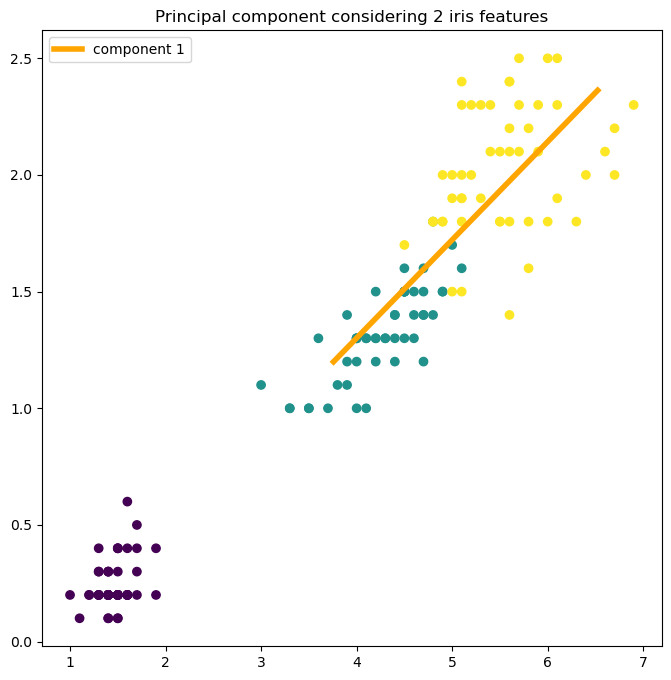

In [7]:
# visualizing principal components: IRIS DATASET
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

#all components now, not doing any real dimensionality reduction
irisData = load_iris()
X, y = irisData["data"], irisData["target"]
pca = PCA()
X_transf = pca.fit_transform(X[:, 2:]) #PCA/fit_transform on last 2 features
plt.figure(figsize=(8,8))
plt.scatter(X[:, 2], X[:, 3],c=y) #scatters last and second last features from the iris dataset

#we add the mean to each component for our visualization and plot each value from the components_
#length of the line: defined by the components we are adding here
plt.plot([pca.mean_[0], pca.mean_[0] + 3*pca.components_[0,0]], 
         [pca.mean_[1], pca.mean_[1] + 3*pca.components_[0,1]],
         linewidth=4,
         color='orange',
         label='component 1'
        )
plt.legend()
plt.title('Principal component considering 2 iris features')
plt.show()